# Smart Route

In [22]:
import pandas as pd
import numpy as np
import geohash2
from itertools import product
import matplotlib.pyplot as plt

In [23]:
df = pd.read_csv('../datasets/traffic_incidents.csv')

In [24]:
df['acci_time'] = pd.to_datetime(df['acci_time'], dayfirst=True)

df['day'] = df['acci_time'].dt.day
df['month'] = df['acci_time'].dt.month
df['year'] = df['acci_time'].dt.year
df['hour'] = df['acci_time'].dt.hour
df['day_of_week'] = pd.to_datetime(df[['year', 'month', 'day']]).dt.weekday
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)

In [25]:
def to_geohash(lat, lon, precision=7):
    return geohash2.encode(lat, lon, precision=precision)

df['geohash_7'] = df.apply(lambda row: to_geohash(row['acci_x'], row['acci_y'], precision=7), axis=1)

In [26]:
df_sub = df[
    (df['year'] == 2024) & 
    (df['month'].isin([6, 7, 8, 9, 10]))]

In [27]:
# import folium
# from folium.plugins import MarkerCluster
# 
# dubai_map = folium.Map(location=[25.276987, 55.296249], zoom_start=12)
# 
# marker_cluster = MarkerCluster(options={'spiderfyDistanceMultiplier': 1.5}).add_to(dubai_map)
# 
# for _, row in df_sub.iterrows():
#     popup_text = (
#         f"Geohash_7: {row['geohash_7']}<br>"
#         f"Type incident: {row['acci_name_en']}<br>"
#     )
# 
#     folium.CircleMarker(
#         location=[row['acci_x'], row['acci_y']],
#         radius=5,
#         color='blue',
#         fill=True,
#         fill_color='blue',
#         fill_opacity=0.6,
#         popup=folium.Popup(popup_text, max_width=300)
#     ).add_to(marker_cluster)
# 
# folium.LayerControl().add_to(dubai_map)
# 
# dubai_map.save("dubai_map_total.html")

In [28]:
df_sub = df_sub.drop(columns=['acci_time', 'acci_id', 'acci_name'])
df_sub = df_sub.drop(columns=['acci_x', 'acci_y'])

df_sub.drop_duplicates(inplace=True)
df_sub.reset_index(drop=True, inplace=True)

In [29]:
unique_years = df_sub['year'].unique()
unique_hours = df_sub['hour'].unique()
unique_days_of_week = df_sub['day_of_week'].unique()

df_sub = df_sub.assign(target=1)

df_combined = []

for month in sorted(df_sub['month'].unique()): 
    print(f"Process month: {month}")

    accidents_month = df_sub[df_sub['month'] == month]
    unique_days = sorted(accidents_month['day'].unique())

    for day in unique_days:
        accidents_day = accidents_month[accidents_month['day'] == day]
        num_accidents = len(accidents_day)
        max_non_accidents = num_accidents * 10

        unique_geohashes = accidents_day['geohash_7'].unique()

        all_combinations = pd.DataFrame(
            list(product([day], [month], unique_years, unique_hours, unique_geohashes, unique_days_of_week)),
            columns=['day', 'month', 'year', 'hour', 'geohash_7', 'day_of_week']
        )

        all_combinations['target'] = 0

        non_accidents = all_combinations.merge(
            accidents_day[['day', 'month', 'year', 'hour', 'geohash_7', 'day_of_week']],
            on=['day', 'month', 'year', 'hour', 'geohash_7', 'day_of_week'],
            how='left', indicator=True
        ).query('_merge == "left_only"').drop(columns=['_merge'])

        if len(non_accidents) > max_non_accidents:
            non_accidents = non_accidents.sample(n=max_non_accidents, random_state=42)

        df_combined.append(pd.concat([accidents_day, non_accidents], ignore_index=True))

df_combined = pd.concat(df_combined, ignore_index=True)

print(df_combined['target'].value_counts())


Process month: 6
Process month: 7
Process month: 8
Process month: 9
Process month: 10
target
0    413950
1     41395
Name: count, dtype: int64


In [30]:
geohash_stats = df_combined.groupby('geohash_7').agg(
    accidents_count=('target', 'sum'),  
    total_count=('target', 'count')   
).reset_index()

geohash_stats['accident_probability'] = geohash_stats['accidents_count'] / geohash_stats['total_count']

df_combined = df_combined.merge(geohash_stats, on='geohash_7', how='left')
df_combined['is_weekend'] = df_combined['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)

In [31]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

selected_features = ['accident_probability', 'day', 'hour', 'day_of_week', 'geohash_7', 'month']

X = df_combined[selected_features]
y = df_combined['target']

categorical_features_indices = np.where(X.dtypes != float)[0]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.9, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    depth=4,
    random_seed=42,
    eval_metric='Precision',
    cat_features=categorical_features_indices,
    class_weights=[1, 4],
    l2_leaf_reg=3,
    early_stopping_rounds=50,
    verbose=100,
    task_type="CPU"
)

model.fit(X_train, y_train, eval_set=(X_validation, y_validation))

y_val_pred = model.predict(X_validation)
y_val_pred_proba = model.predict_proba(X_validation)[:, 1]
print("Validation Classification Report:\n", classification_report(y_validation, y_val_pred))
print("AUC-ROC on the validation subset:", roc_auc_score(y_validation, y_val_pred_proba))

y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)[:, 1]
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))
print("AUC-ROC on the test subset:", roc_auc_score(y_test, y_test_pred_proba))

0:	learn: 0.6038715	test: 0.8154602	best: 0.8154602 (0)	total: 133ms	remaining: 2m 12s
100:	learn: 0.8712717	test: 0.9513783	best: 0.9525192 (82)	total: 4.11s	remaining: 36.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9525192391
bestIteration = 82

Shrink model to first 83 iterations.
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     20710
           1       0.83      0.80      0.82      2057

    accuracy                           0.97     22767
   macro avg       0.91      0.89      0.90     22767
weighted avg       0.97      0.97      0.97     22767

AUC-ROC on the validation subset: 0.9780775423369742
Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     20715
           1       0.84      0.79      0.81      2053

    accuracy                           0.97     22768
   macro avg       0.91   

Feature Importances:
                Feature  Importance
1                   day   30.299478
2                  hour   24.663720
3           day_of_week   22.757982
5                 month   12.198893
4             geohash_7    8.449915
0  accident_probability    1.630012


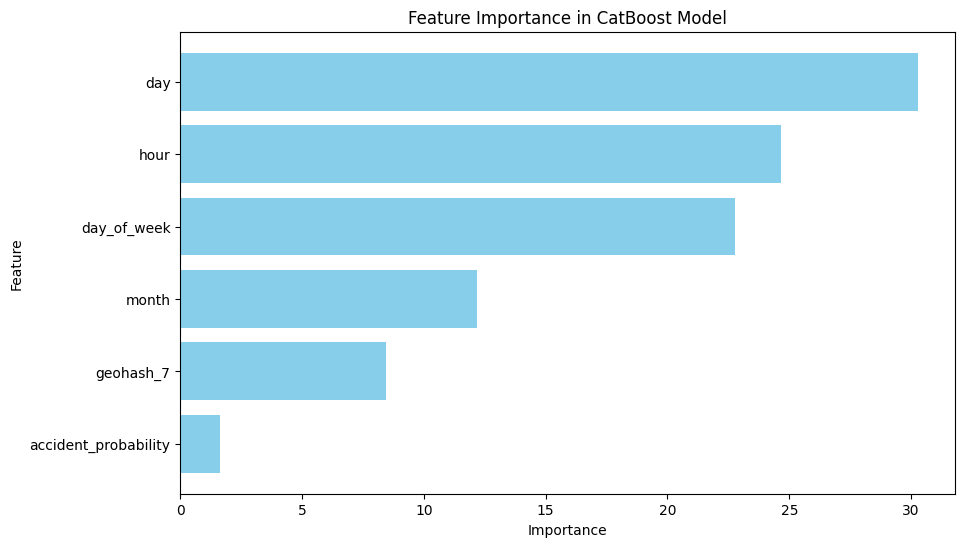

In [32]:
feature_importances = model.feature_importances_
feature_names = selected_features

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in CatBoost Model')
plt.gca().invert_yaxis()
plt.show()

In [33]:
import osmnx as ox
import networkx as nx
import folium
import pandas as pd
import numpy as np
import geohash2
from datetime import datetime, timedelta


def get_route_coords(G, start, end):
    orig_node = ox.distance.nearest_nodes(G, start[1], start[0])
    dest_node = ox.distance.nearest_nodes(G, end[1], end[0])
    route = nx.shortest_path(G, orig_node, dest_node, weight="length")
    route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in route]
    return route_coords


def interpolate_route(route_coords, step_km=0.1):
    interpolated_coords = [route_coords[0]]
    for i in range(len(route_coords) - 1):
        start = np.array(route_coords[i])
        end = np.array(route_coords[i + 1])
        distance = ox.distance.great_circle(start[0], start[1], end[0], end[1]) / 1000
        if distance > step_km:
            num_steps = int(distance / step_km)
            for step in range(1, num_steps + 1):
                interpolated_point = start + (end - start) * (step / num_steps)
                interpolated_coords.append(tuple(interpolated_point))
        interpolated_coords.append(route_coords[i + 1])
    return interpolated_coords


def prepare_route_data(route_data):
    route_data['geohash_7'] = route_data['geohash_7'].astype('category')
    route_data['accidents_count'] = route_data['accidents_count'].astype('category')
    route_data['day'] = route_data['day'].astype('int')
    route_data['hour'] = route_data['hour'].astype('int')
    route_data['day_of_week'] = route_data['day_of_week'].astype('int')
    route_data['month'] = route_data['month'].astype('int')
    route_data['accident_probability'] = route_data['accident_probability'].astype('float')
    return route_data


start_coords = (25.0806, 55.1389)  # Dubai Marina
town_square_coords = (25.0117, 55.2888)  # Town Square
jvc_coords = (25.0621, 55.2095)  # Jumeirah Lakes Towers (JLT)
end_coords = (25.2711, 55.3075)  # Deira
start_time = datetime(2026, 8, 15, 19, 0)
speed_kmph = 60
step_km = 0.25

G = ox.graph_from_place("Dubai, UAE", network_type="drive")

route_coords1 = get_route_coords(G, start_coords, jvc_coords)
route_coords2 = get_route_coords(G, jvc_coords, town_square_coords)
route_coords3 = get_route_coords(G, town_square_coords, end_coords)

route_coords = route_coords1 + route_coords2[1:] + route_coords3[1:]
route_coords = interpolate_route(route_coords, step_km=step_km)

timestamps = [start_time]
for i in range(len(route_coords) - 1):
    dist_km = ox.distance.great_circle(
        route_coords[i][0], route_coords[i][1],
        route_coords[i + 1][0], route_coords[i + 1][1]
    ) / 1000
    time_delta = timedelta(hours=dist_km / speed_kmph)
    timestamps.append(timestamps[-1] + time_delta)

route_data = pd.DataFrame({
    'month': [ts.month for ts in timestamps],
    'day': [ts.day for ts in timestamps],
    'day_of_week': [ts.weekday() for ts in timestamps],
    'hour': [ts.hour for ts in timestamps],
    'latitude': [lat for lat, lon in route_coords],
    'longitude': [lon for lat, lon in route_coords],
    'accidents_count': 0,
    'accident_probability': 0.0
})

route_data['geohash_7'] = route_data.apply(
    lambda row: geohash2.encode(row['latitude'], row['longitude'], precision=7), axis=1
)
route_data['is_weekend'] = route_data['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)

route_data = prepare_route_data(route_data)

predicted_risk = []
for i in range(len(route_data)):
    point_data = route_data.iloc[[i]][selected_features]
    risk = model.predict_proba(point_data)[:, 1][0]
    predicted_risk.append(risk)

route_data['predicted_risk'] = predicted_risk

In [35]:
route_map = folium.Map(location=start_coords, zoom_start=13)

for i in range(len(route_coords) - 1):
    folium.PolyLine(
        locations=[route_coords[i], route_coords[i + 1]],
        color="blue",
        weight=3,
        opacity=0.6
    ).add_to(route_map)

folium.Marker(start_coords, tooltip="Dubai Marina", icon=folium.Icon(color="green")).add_to(route_map)
folium.Marker(jvc_coords, tooltip="Jumeirah Village Circle (JVC)", icon=folium.Icon(color="orange")).add_to(route_map)
folium.Marker(town_square_coords, tooltip="Town Square", icon=folium.Icon(color="purple")).add_to(route_map)
folium.Marker(end_coords, tooltip="Deira", icon=folium.Icon(color="red")).add_to(route_map)

risk_thresholds = [0.43, 0.45, 0.50]
for _, row in route_data.iterrows():
    if row['predicted_risk'] >= risk_thresholds[2]:
        color = "red"
    elif row['predicted_risk'] >= risk_thresholds[1]:
        color = "coral"
    elif row['predicted_risk'] >= risk_thresholds[0]:
        color = "orange"
    else:
        continue 
    
    if color:  
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=7,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=f"Accident prob: {row['predicted_risk']:.2f}, Time: {row['hour']}:00"
        ).add_to(route_map)

route_map
route_map.save("route_map.html")

In [67]:
route_data

,month,day,day_of_week,hour,latitude,longitude,accidents_count,accident_probability,geohash_7,is_weekend,predicted_risk
0,8,15,5,19,25.080220,55.139180,0,0.0,thrnwtx,1,0.160927
1,8,15,5,19,25.080447,55.139995,0,0.0,thrnwtz,1,0.399684
2,8,15,5,19,25.078558,55.142319,0,0.0,thrnwv3,1,0.407319
3,8,15,5,19,25.078558,55.142319,0,0.0,thrnwv3,1,0.407319
4,8,15,5,19,25.078392,55.142524,0,0.0,thrnwv3,1,0.407319
...,...,...,...,...,...,...,...,...,...,...,...
458,8,15,5,20,25.270184,55.306172,0,0.0,thrrf82,1,0.247479
459,8,15,5,20,25.270194,55.306420,0,0.0,thrrf82,1,0.247479
460,8,15,5,20,25.270948,55.306462,0,0.0,thrrf82,1,0.247479
461,8,15,5,20,25.271053,55.306835,0,0.0,thrrf83,1,0.238379


In [69]:
model.save_model("catboost_model.cbm")